In [1]:
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, suppress=True)
from collections import Counter, defaultdict
import importlib

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
mpl.rc("savefig", dpi=300)

# Read data

In [3]:
pred_dir = '../result/cv_pred/'

## Read observed values and drug stats

In [4]:
obs_df_dict = {}
for k in range(1, 5+1):
    obs_df = pd.read_csv('../preprocessed_data/GDSC/cv_data/Y_test_5f_{}.csv'.format(k), index_col=0)
    obs_df.index = obs_df.index.astype(str)
    obs_df_dict[k] = obs_df

In [5]:
drug_df = pd.read_csv('../preprocessed_data/GDSC/drug_stat.csv', index_col=0) #[['Drug Name', 'max_conc', 'log2_max_conc', 'num_cl']]
drug_df.index = drug_df.index.astype(str)
drug_df.head()

,Drug Name,Synonyms,Target,Target Pathway,Selleckchem Cat#,CAS number,PubCHEM,Others,entropy,max_conc,...,median_ic50_9f,log2_median_ic50_9f,log2_median_ic50_hn,median_ic50_hn,median_ic50_3f_hn,log2_median_ic50_3f_hn,median_ic50_9f_hn,log2_median_ic50_9f_hn,num_sensitive,num_sensitive_hn
Drug ID,,,,,,,,,,,,,,,,,,,,,
1,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling,S7786,183321-74-6,176870,"(S1023, 183319-69-9, HCl)",7.045609,2.0,...,8.448890,3.078762,7.764640,217.465095,72.488365,6.179678,24.162788,4.594715,17,1
1001,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole...",AMPK agonist,Metabolism,S1802,2627-69-2,65110,NaN,6.034272,2000.0,...,206.748380,7.691732,9.939784,982.139588,327.379863,8.354822,109.126621,6.769859,476,27
1003,Camptothecin,"7-Ethyl-10-Hydroxy-Camptothecin, SN-38, Irinot...",TOP1,DNA replication,S1288,7689-03-4,104842,"(SN-38, S4908, 86639-52-3) (Irinotecan, S1198,...",4.609530,0.1,...,0.002003,-8.963413,-7.587491,0.005199,0.001733,-9.172454,0.000578,-10.757416,688,30
1004,Vinblastine,Velban,Microtubule destabiliser,Mitosis,S1248,143-67-9,6710780,NaN,4.297122,0.1,...,0.001599,-9.289051,-7.150982,0.007036,0.002345,-8.735945,0.000782,-10.320907,753,33
1005,Cisplatin,"cis-Diammineplatinum(II) dichloride, Platinol,...",DNA crosslinker,DNA replication,S1166,15663-27-1,84691,NaN,7.203618,6.0,...,1.328214,0.409488,3.486279,11.206619,3.735540,1.901317,1.245180,0.316354,175,9


In [6]:
drug_id_log2_max_conc_dict = dict(zip(drug_df.index, drug_df['log2_max_conc']))

## CaDRReS and CaDRReS-Sc

In [7]:
cadrres_df_dict = {}
for k in range(1, 5+1):
    pred_pickle = pickle.load(open(pred_dir + 'cadrres_5f_{}_output_dict.pickle'.format(k), 'rb'))
    pred_df = pred_pickle['pred_test_df']
    pred_df.index = pred_df.index.astype(str)
    cadrres_df_dict[k] = pred_df

In [8]:
cadrres_sc_df_dict = {}
for k in range(1, 5+1):
    pred_pickle = pickle.load(open(pred_dir + 'cadrres-wo-sample-bias-weight_5f_{}_output_dict.pickle'.format(k), 'rb'))
    pred_df = pred_pickle['pred_test_df']
    pred_df.index = pred_df.index.astype(str)
    cadrres_sc_df_dict[k] = pred_df

## ElasticNet

In [9]:
elasticnet_df_dict = {}
for k in range(1, 5+1):
    pred_df = pd.read_csv(pred_dir + 'ElasticNet_5f_{}.csv'.format(k))
    pred_df.index = pred_df.index.astype(str)
    elasticnet_df_dict[k] = pred_df

## RWEN

In [10]:
rwen_df_dict = {}
for k in range(1, 5+1):
    pred_df = pd.read_csv(pred_dir + 'RWEN_5f_{}_pred.csv'.format(k))
    pred_df.index = pred_df.index.astype(str)
    rwen_df_dict[k] = pred_df

## cwKBMF

In [11]:
cwkbmf_df_dict = {}
for k in range(1, 5+1):
    pred_df = pd.read_csv(pred_dir + 'cwKBMF_5f_{}_denorm.csv'.format(k))
    pred_df.index = pred_df.index.astype(str)
    cwkbmf_df_dict[k] = pred_df

## SRMF

In [12]:
srmf_df_dict = {}
for k in range(1, 5+1):
    pred_df = pd.read_csv(pred_dir + 'SRMF_5f_{}_pred_final.csv'.format(k))
    pred_df.index = pred_df.index.astype(str)
    srmf_df_dict[k] = pred_df

In [13]:
pred_dict = {}
pred_dict['CaDRReS'] = cadrres_df_dict
pred_dict['CaDRReS-Sc'] = cadrres_sc_df_dict
pred_dict['ElasticNet'] = elasticnet_df_dict
pred_dict['RWEN'] = rwen_df_dict
pred_dict['cwKBMF'] = cwkbmf_df_dict
pred_dict['SRMF'] = srmf_df_dict

In [14]:
model_list = sorted(list(pred_dict.keys()))

# Evaluation metrics

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_curve, mean_absolute_error, auc, r2_score, mean_squared_error
min_samples = 5

In [47]:
results = []

for k in range(1, 5+1):
    print (k, '...')

    obs_df = obs_df_dict[k]
    drug_list = obs_df.columns
    for m, pred_df_dict in pred_dict.items():
        pred_df = pred_df_dict[k]
        
        for d in drug_list:
            d_max = drug_id_log2_max_conc_dict[d]
            y = obs_df[d].values
            y_pred = pred_df[d].values
            sel_bool = ~np.isnan(y)
            
            y = y[sel_bool]
            y_pred = y_pred[sel_bool]
            
            y_class = y <= d_max
            y_pred_class = y_pred <= d_max
            n_sensitive = np.sum(y_class)
            n_obs = len(y_class)
            
            if n_sensitive >= min_samples:
                
                # All (not in use)
                mse_all = mean_squared_error(y, y_pred)
                scor_all, _ = stats.spearmanr(y, y_pred)
                
                # Classification
                acc = accuracy_score(y_class, y_pred_class)
                prec, rec, thd  = precision_recall_curve(y_class, -1*y_pred)
                pr_auc = auc(rec, prec)

                # Regression (sensitive case)
                r2 = r2_score(y[y_class], y_pred[y_class])
                mae = mean_absolute_error(y[y_class], y_pred[y_class])
                median_ae = np.median(np.abs(y[y_class] - y_pred[y_class]))
                mae_relative = np.mean(np.abs((y[y_class] - y_pred[y_class])/y[y_class])*100)
                median_ae_relative = np.median(np.abs((y[y_class] - y_pred[y_class])/y[y_class])*100)
                
                # unlog version
                y_unlog = np.power(2, y[y_class])
                y_pred_unlog = np.power(2, y_pred[y_class])

                r2_unlog = r2_score(y_unlog, y_pred_unlog)
                mae_unlog = mean_absolute_error(y_unlog, y_pred_unlog)
                median_ae_unlog = np.median(np.abs(y_unlog - y_pred_unlog))
                mae_relative_unlog = np.mean(np.abs((y_unlog - y_pred_unlog)/y_unlog)*100)
                median_ae_relative_unlog = np.median(np.abs((y_unlog - y_pred_unlog)/y_unlog)*100)
                
                results += [[k, m, d, d_max, acc, pr_auc, 
                             mae, median_ae, mae_relative, median_ae_relative, r2, 
                             mae_unlog, median_ae_unlog, mae_relative_unlog, median_ae_relative_unlog, r2_unlog,
                             mse_all, scor_all, n_obs, n_sensitive]]


1 ...
2 ...
3 ...
4 ...
5 ...


In [48]:
result_df = pd.DataFrame(results, columns=['k', 'Model', 'Drug', 'Log2 max conc', 'Accuracy', 'PR-AUC', 
                                           'MAE', 'MedianAE', 'MAE_relative', 'MedianAE_relative', 'R2', 
                                           'MAE_unlog', 'MedianAE_unlog', 'MAE_relative_unlog', 'MedianAE_relative_unlog', 'R2_unlog',
                                           'MSE (all)', 'Spearman r (all)', '#', '# sensitive'])
result_df.head()

,k,Model,Drug,Log2 max conc,Accuracy,PR-AUC,MAE,MedianAE,MAE_relative,MedianAE_relative,R2,MAE_unlog,MedianAE_unlog,MAE_relative_unlog,MedianAE_relative_unlog,R2_unlog,MSE (all),Spearman r (all),#,# sensitive
0,1,CaDRReS,1001,10.965784,0.563218,0.689830,1.784807,1.478582,19.052372,15.212697,-3.832748,1279.654625,787.407502,244.213027,79.375115,-17.675754,5.475658,0.245753,174,92
1,1,CaDRReS,1003,-3.321928,0.804598,0.913770,2.154714,1.857038,33.946139,27.827255,-1.102976,0.033388,0.013706,628.598878,81.619098,-7.117502,12.341072,0.417459,174,135
2,1,CaDRReS,1004,-3.321928,0.834286,0.942615,2.067291,1.794265,34.531097,27.262572,-1.618674,0.035163,0.012228,430.954609,86.635412,-15.989322,11.033894,0.327718,175,147
3,1,CaDRReS,1005,2.584963,0.651429,0.232954,1.812944,1.569073,180.580829,71.703831,-14.135857,13.636464,3.775439,351.070751,82.237883,-363.448069,7.061397,0.279064,175,31
4,1,CaDRReS,1006,1.000000,0.634286,0.741611,2.131068,1.672974,1022.999511,187.354399,-1.780196,2.035314,0.827161,530.093919,87.996859,-59.949755,13.092780,0.335961,175,98


In [49]:
drug_result_df = result_df.groupby(by=['Model', 'Drug']).mean().drop('k', axis=1).reset_index()
drug_result_df.head()

,Model,Drug,Log2 max conc,Accuracy,PR-AUC,MAE,MedianAE,MAE_relative,MedianAE_relative,R2,MAE_unlog,MedianAE_unlog,MAE_relative_unlog,MedianAE_relative_unlog,R2_unlog,MSE (all),Spearman r (all),#,# sensitive
0,CaDRReS,1,1.000000,0.725806,0.097515,5.314421,5.755685,1586.938211,690.823134,-8.184285,57.987418,27.604131,34162.894880,5302.985171,-18922.419888,18.539862,0.298179,62.0,7.0
1,CaDRReS,1001,10.965784,0.594541,0.716846,1.708496,1.471741,17.964147,15.099543,-3.538292,1248.046579,653.154972,187.216563,73.504550,-26.947715,6.389256,0.330530,168.4,91.2
2,CaDRReS,1003,-3.321928,0.778412,0.886219,2.188763,1.812258,35.152808,26.033161,-1.044009,0.048464,0.011176,2089.649091,83.486957,-108.519393,15.556958,0.398649,169.8,131.4
3,CaDRReS,1004,-3.321928,0.824640,0.914510,1.875369,1.596772,31.657793,24.282578,-1.215823,0.044461,0.009016,404.390277,78.277730,-133.221946,11.582113,0.416246,170.0,143.8
4,CaDRReS,1005,2.584963,0.609240,0.310729,1.693670,1.366396,150.941075,73.958084,-7.882467,16.586475,3.032064,895.807276,75.396784,-3566.444877,8.591101,0.307271,170.0,33.2


# Indication-specific mode

In [50]:
gdsc_sample_df = pd.read_csv('../data/GDSC/GDSC_tissue_info.csv', index_col=0)
gdsc_sample_df.index = gdsc_sample_df.index.astype(str)
gdsc_sample_df.head()

,NAME,TCGA_CLASS,TISSUE,SUBTYPE
CELL_LINE,,,,
1287381,201T,LUAD,lung,lung_NSCLC_adenocarcinoma
924100,22RV1,PRAD,urogenital_system,prostate
910924,23132-87,STAD,digestive_system,stomach
687561,42-MG-BA,GBM,nervous_system,glioma
1287706,451Lu,SKCM,skin,melanoma


In [51]:
selected_incations = ['SCLC', 'LUAD', 'SKCM', 'BRCA', 'COREAD', 'HNSC']

In [52]:
indication_pred_df_dict = {} 
indication_sample_dict = {}

for k in range(1, 5+1):
    indication_pred_df_dict[k] = {}
    
    for i in selected_incations:
        indication_pred_df_dict[k][i] = {}
        
        if k == 1:
            indication_sample_dict[i] = list(gdsc_sample_df[gdsc_sample_df['TCGA_CLASS']==i].index.astype(str))
        
        for w in [1, 5, 10]:
            pred_pickle = pickle.load(open(pred_dir + 'cadrres-wo-sample-bias-weight_{}_{}_5f_{}_output_dict.pickle'
                                           .format(i, w, k), 'rb'))
            pred_df = pred_pickle['pred_test_df']
            pred_df.index = pred_df.index.astype(str)
            indication_pred_df_dict[k][i][w] = pred_df


In [53]:
indication_sample_dict.keys()

dict_keys(['SCLC', 'LUAD', 'SKCM', 'BRCA', 'COREAD', 'HNSC'])

## Evaluation for indication-specific mode

In [54]:
min_samples = 5

In [55]:
results = []

for k in range(1, 5+1):
    print (k, '...')
    
    obs_df = obs_df_dict[k]
    drug_list = obs_df.columns
    
    for i in selected_incations:
        
        i_sample_list = indication_sample_dict[i]
        i_obs_df = obs_df[obs_df.index.isin(i_sample_list)]
        
        for w in [1, 5, 10]:
            
            pred_df = indication_pred_df_dict[k][i][w]
            drug_list = pred_df.columns

            for d in drug_list:
                d_max = drug_id_log2_max_conc_dict[d]
                y = i_obs_df[d].values
                y_pred = pred_df.loc[i_obs_df.index][d].values
                
                sel_bool = ~np.isnan(y)
                
                y = y[sel_bool]
                y_pred = y_pred[sel_bool]

                y_class = y <= d_max
                y_pred_class = y_pred <= d_max
                n_sensitive = np.sum(y_class)
                n_obs = len(y_class)
                
                if n_sensitive >= min_samples:

                    # All (not in use)
                    mse_all = mean_squared_error(y, y_pred)
                    scor_all, _ = stats.spearmanr(y, y_pred)

                    # Classification
                    acc = accuracy_score(y_class, y_pred_class)
                    prec, rec, thd  = precision_recall_curve(y_class, -1*y_pred)
                    pr_auc = auc(rec, prec)


                    # Regression (sensitive case)
                    mae = mean_absolute_error(y[y_class], y_pred[y_class])
                    r2 = r2_score(y[y_class], y_pred[y_class])

                    results += [[k, i, w, d, acc, pr_auc, mae, r2, mse_all, scor_all, n_obs, n_sensitive]]
                


1 ...
2 ...
3 ...
4 ...
5 ...


In [56]:
result_indication_df = pd.DataFrame(results, columns=['k', 'Indication', 'Indication weight', 'Drug', 'Accuracy', 'PR-AUC', 'MAE', 'R2', 'MSE (all)', 'Spearman r (all)', '#', '# sensitive'])
result_indication_df.head()

,k,Indication,Indication weight,Drug,Accuracy,PR-AUC,MAE,R2,MSE (all),Spearman r (all),#,# sensitive
0,1,SCLC,1,1001,0.454545,0.350455,2.932404,-55.143913,21.319853,-0.345455,11,5
1,1,SCLC,1,1003,0.545455,0.743414,3.259384,-0.624621,11.804595,0.336364,11,7
2,1,SCLC,1,1004,0.636364,0.975154,3.052172,-4.157741,11.623410,0.136364,11,9
3,1,SCLC,1,1011,0.900000,1.000000,1.464405,-2.628730,5.800678,0.406061,10,9
4,1,SCLC,1,1012,1.000000,1.000000,0.737720,-0.290934,0.837762,0.363636,11,11


In [57]:
drug_result_indication_df = result_indication_df.groupby(by=['Indication', 'Indication weight', 'Drug']).mean().drop('k', axis=1).reset_index()
print (drug_result_indication_df['Drug'].unique().shape)
drug_result_indication_df.head()

(113,)


,Indication,Indication weight,Drug,Accuracy,PR-AUC,MAE,R2,MSE (all),Spearman r (all),#,# sensitive
0,BRCA,1,1001,0.621190,0.794811,2.175313,-15.598682,14.019360,0.095844,8.8,5.40
1,BRCA,1,1003,0.500000,0.730215,2.078715,-2.633882,16.101956,0.090909,10.0,7.00
2,BRCA,1,1004,0.787778,0.863518,1.938295,-5.525227,10.657797,0.366450,8.8,6.20
3,BRCA,1,1007,0.579266,0.875808,2.370896,-17.474151,15.378907,0.493452,8.5,5.75
4,BRCA,1,1012,0.828413,0.934025,1.096268,-0.945400,2.545512,0.148701,8.8,7.60


# Figures

## Performance per drug

In [58]:
# score_name = 'MAE'

# sorted_model_list = drug_result_df.groupby('Model').mean().sort_values(score_name).index
# sorted_model_list = [m for m in sorted_model_list if m != 'CaDRReS']

# sns.set(font_scale=1.2)
# sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# fig, ax = plt.subplots(figsize=(4,4))

# sns.barplot(data=drug_result_df, x='Model', y=score_name, ci='sd', order=sorted_model_list, color='skyblue', ax=ax)
# # sns.swarmplot(data=drug_result_df, x='Model', y=score_name, order=sorted_model_list, color='black', s=2, alpha=0.75)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('Mean Absolute Error\n(sensitive)')
# # ax.set_yscale('log', basey=10)

# plt.tight_layout()
# sns.despine()

In [59]:
columns=['k', 'Model', 'Drug', 'Log2 max conc', 'Accuracy', 'PR-AUC', 
       'MAE', 'MedianAE', 'MAE_relative', 'MedianAE_relative', 'R2', 
       'MAE_unlog', 'MedianAE_unlog', 'MAE_relative_unlog', 'MedianAE_relative_unlog', 'R2_unlog',
       'MSE (all)', 'Spearman r (all)', '#', '# sensitive']

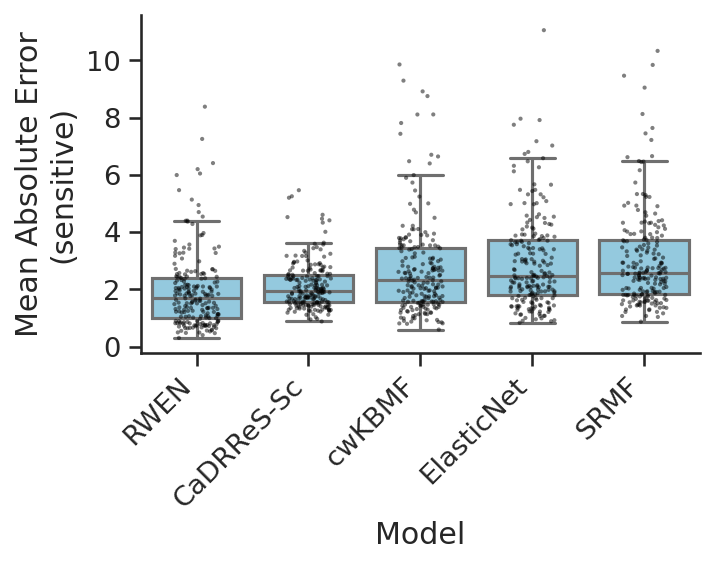

In [89]:
score_name = 'MAE' # MAE_unlog, MAE_relative, MedianAE_relative_unlog

sorted_model_list = drug_result_df.groupby('Model').mean().sort_values(score_name).index
sorted_model_list = [m for m in sorted_model_list if m != 'CaDRReS']

sns.set(font_scale=1.2)
# sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5,4))

# sns.barplot(data=drug_result_df, x='Model', y=score_name, ci=95, order=sorted_model_list, color='skyblue', ax=ax)
# sns.violinplot(data=drug_result_df, x='Model', y=score_name, order=sorted_model_list, color='skyblue')
sns.boxplot(data=drug_result_df, x='Model', y=score_name, order=sorted_model_list, color='skyblue', fliersize=0)
sns.stripplot(data=drug_result_df, x='Model', y=score_name, order=sorted_model_list, color='black', jitter=0.2, s=2, alpha=0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Mean Absolute Error\n(sensitive)')
# ax.set_ylim((0, 10))
# ax.set_yscale('log', basey=10)

plt.tight_layout()
sns.despine()
# plt.savefig('../figure/performance_MedianAE_relative_unlog.svg')

### Investigate unlog version

In [89]:
y1 = np.arange(-5, 5, 1)
y1_pred = np.array([-5, -3, -4, -1, -2, 0, 2, 1, 4, 3])
y2 = y1+5
y2_pred = y1_pred+5
y3 = y1-5
y3_pred = y1_pred-5

y1, y1_pred

(array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4]),
 array([-5, -3, -4, -1, -2,  0,  2,  1,  4,  3]))

In [90]:
cnt = 1

for y, y_pred in zip([y1, y2, y3], [y1_pred, y2_pred, y3_pred]):

    y_unlog = np.power(2.0, y)
    y_pred_unlog = np.power(2.0, y_pred)

#     print (y_unlog)
#     print (y_pred_unlog)

    print (np.abs(y-y_pred))
    print (np.mean(np.abs(y-y_pred)))

    print (np.abs(y_unlog-y_pred_unlog))
    print (np.mean(np.abs(y_unlog-y_pred_unlog)))
    
    print (np.mean(np.power(2.0, np.abs(y-y_pred))))

    df = pd.DataFrame([y, y_pred, np.abs(y-y_pred), np.power(2.0, np.abs(y-y_pred)), y_unlog, y_pred_unlog, np.abs(y_unlog-y_pred_unlog)])
    df.index = ['y', 'y_pred', 'abs_error', 'abs_err_unlog', 'y_unlog', 'y_pred_unlog', 'abs_error_from_unlog']
    df.columns = ['Sample{:02d}'.format(i+1) for i in range(10)]
    df.index.name = 'Drug{}'.format(cnt)
    display(df)
    
    cnt += 1

[0 1 1 1 1 0 1 1 1 1]
0.8
[0.   0.06 0.06 0.25 0.25 0.   2.   2.   8.   8.  ]
2.0625
1.8


,Sample01,Sample02,Sample03,Sample04,Sample05,Sample06,Sample07,Sample08,Sample09,Sample10
Drug1,,,,,,,,,,
y,-5.00000,-4.0000,-3.0000,-2.00,-1.00,0.0,1.0,2.0,3.0,4.0
y_pred,-5.00000,-3.0000,-4.0000,-1.00,-2.00,0.0,2.0,1.0,4.0,3.0
abs_error,0.00000,1.0000,1.0000,1.00,1.00,0.0,1.0,1.0,1.0,1.0
abs_err_unlog,1.00000,2.0000,2.0000,2.00,2.00,1.0,2.0,2.0,2.0,2.0
y_unlog,0.03125,0.0625,0.1250,0.25,0.50,1.0,2.0,4.0,8.0,16.0
y_pred_unlog,0.03125,0.1250,0.0625,0.50,0.25,1.0,4.0,2.0,16.0,8.0
abs_error_from_unlog,0.00000,0.0625,0.0625,0.25,0.25,0.0,2.0,2.0,8.0,8.0


[0 1 1 1 1 0 1 1 1 1]
0.8
[  0.   2.   2.   8.   8.   0.  64.  64. 256. 256.]
66.0
1.8


,Sample01,Sample02,Sample03,Sample04,Sample05,Sample06,Sample07,Sample08,Sample09,Sample10
Drug2,,,,,,,,,,
y,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
y_pred,0.0,2.0,1.0,4.0,3.0,5.0,7.0,6.0,9.0,8.0
abs_error,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
abs_err_unlog,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
y_unlog,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0
y_pred_unlog,1.0,4.0,2.0,16.0,8.0,32.0,128.0,64.0,512.0,256.0
abs_error_from_unlog,0.0,2.0,2.0,8.0,8.0,0.0,64.0,64.0,256.0,256.0


[0 1 1 1 1 0 1 1 1 1]
0.8
[0.   0.   0.   0.01 0.01 0.   0.06 0.06 0.25 0.25]
0.064453125
1.8


,Sample01,Sample02,Sample03,Sample04,Sample05,Sample06,Sample07,Sample08,Sample09,Sample10
Drug3,,,,,,,,,,
y,-10.000000,-9.000000,-8.000000,-7.000000,-6.000000,-5.00000,-4.0000,-3.0000,-2.00,-1.00
y_pred,-10.000000,-8.000000,-9.000000,-6.000000,-7.000000,-5.00000,-3.0000,-4.0000,-1.00,-2.00
abs_error,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.0000,1.0000,1.00,1.00
abs_err_unlog,1.000000,2.000000,2.000000,2.000000,2.000000,1.00000,2.0000,2.0000,2.00,2.00
y_unlog,0.000977,0.001953,0.003906,0.007812,0.015625,0.03125,0.0625,0.1250,0.25,0.50
y_pred_unlog,0.000977,0.003906,0.001953,0.015625,0.007812,0.03125,0.1250,0.0625,0.50,0.25
abs_error_from_unlog,0.000000,0.001953,0.001953,0.007812,0.007812,0.00000,0.0625,0.0625,0.25,0.25


In [91]:
n_pair = 10
for m1 in range(len(sorted_model_list)-1):
    for m2 in range(m1+1, len(sorted_model_list)):
        x = drug_result_df[drug_result_df['Model']==sorted_model_list[m1]][score_name].values
        y = drug_result_df[drug_result_df['Model']==sorted_model_list[m2]][score_name].values
        s, p = stats.ranksums(x, y)
        print (sorted_model_list[m1], sorted_model_list[m2], p, p*n_pair)

CaDRReS-Sc RWEN 0.17333856246735768 1.7333856246735768
CaDRReS-Sc cwKBMF 1.601330750707988e-06 1.601330750707988e-05
CaDRReS-Sc ElasticNet 0.01598365320398575 0.15983653203985748
CaDRReS-Sc SRMF 2.641207418217697e-07 2.641207418217697e-06
RWEN cwKBMF 0.04567727665588737 0.45677276655887367
RWEN ElasticNet 0.4282088318843803 4.282088318843803
RWEN SRMF 0.0042557439423335595 0.04255743942333559
cwKBMF ElasticNet 0.21937519088498703 2.1937519088498703
cwKBMF SRMF 0.026469985600709598 0.264699856007096
ElasticNet SRMF 0.05875717865595716 0.5875717865595715


### Prediction accuracy

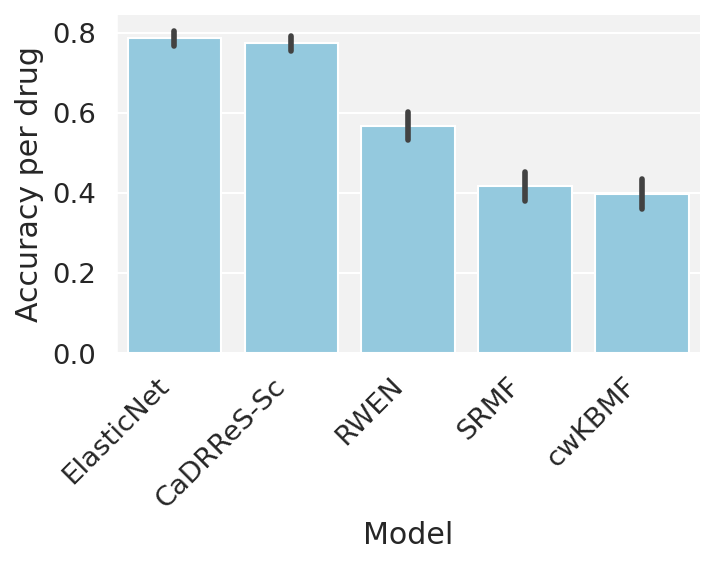

In [92]:
score_name = 'Accuracy'

sorted_model_list = drug_result_df.groupby('Model').mean().sort_values(score_name, ascending=False).index
sorted_model_list = [m for m in sorted_model_list if m != 'CaDRReS']

sns.set(font_scale=1.2)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax = plt.subplots(figsize=(5,4))

sns.barplot(data=drug_result_df, x='Model', y=score_name, ci=95, order=sorted_model_list, color='skyblue', ax=ax)
# sns.swarmplot(data=drug_result_df, x='Model', y=score_name, order=sorted_model_list, color='black', s=2, alpha=0.75)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Accuracy per drug')

plt.tight_layout()
sns.despine()
plt.savefig('../figure/performance_accuracy.svg')

In [93]:
n_pair = 10
for m1 in range(len(sorted_model_list)-1):
    for m2 in range(m1+1, len(sorted_model_list)):
        x = drug_result_df[drug_result_df['Model']==sorted_model_list[m1]][score_name].values
        y = drug_result_df[drug_result_df['Model']==sorted_model_list[m2]][score_name].values
        s, p = stats.ranksums(x, y)
        print (sorted_model_list[m1], sorted_model_list[m2], p, p*n_pair)

ElasticNet CaDRReS-Sc 0.41139931378106454 4.113993137810645
ElasticNet RWEN 5.044924785903705e-18 5.044924785903705e-17
ElasticNet SRMF 5.506593350688283e-40 5.5065933506882834e-39
ElasticNet cwKBMF 1.1696060793622587e-37 1.1696060793622587e-36
CaDRReS-Sc RWEN 3.475277433413206e-16 3.475277433413206e-15
CaDRReS-Sc SRMF 5.499747992421984e-38 5.4997479924219835e-37
CaDRReS-Sc cwKBMF 9.316703705840754e-36 9.316703705840754e-35
RWEN SRMF 2.2761570728471778e-08 2.2761570728471778e-07
RWEN cwKBMF 4.4896597276741664e-10 4.489659727674166e-09
SRMF cwKBMF 0.35097049173132255 3.5097049173132255


In [94]:
# score_name = 'PR-AUC'

# sorted_model_list = drug_result_df.groupby('Model').mean().sort_values(score_name, ascending=False).index

# sns.set(font_scale=1.2)
# sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# fig, ax = plt.subplots(figsize=(4,4))

# sns.barplot(data=drug_result_df, x='Model', y=score_name, ci='sd', order=sorted_model_list, color='skyblue', ax=ax)
# # sns.swarmplot(data=drug_result_df, x='Model', y=score_name, order=sorted_model_list, color='black', s=2, alpha=0.75)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('Precision-Recall AUC\n(sensitive)')
# ax.set_ylim(bottom=0.4)

# plt.tight_layout()
# sns.despine()
# plt.savefig('../figure/performance_pr_auc.svg')

In [95]:
# score_name = 'Spearman r (all)'

# sorted_model_list = drug_result_df.groupby('Model').mean().sort_values(score_name, ascending=False).index

# sns.set(font_scale=1.2)
# sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# fig, ax = plt.subplots(figsize=(4,4))

# sns.barplot(data=drug_result_df, x='Model', y=score_name, ci='sd', order=sorted_model_list, color='skyblue', ax=ax)
# # sns.swarmplot(data=drug_result_df, x='Model', y=score_name, order=sorted_model_list, color='black', s=2, alpha=0.75)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# plt.tight_layout()
# sns.despine()
# plt.savefig('../figure/performance_all_scor.svg')

## Performance scatter plots

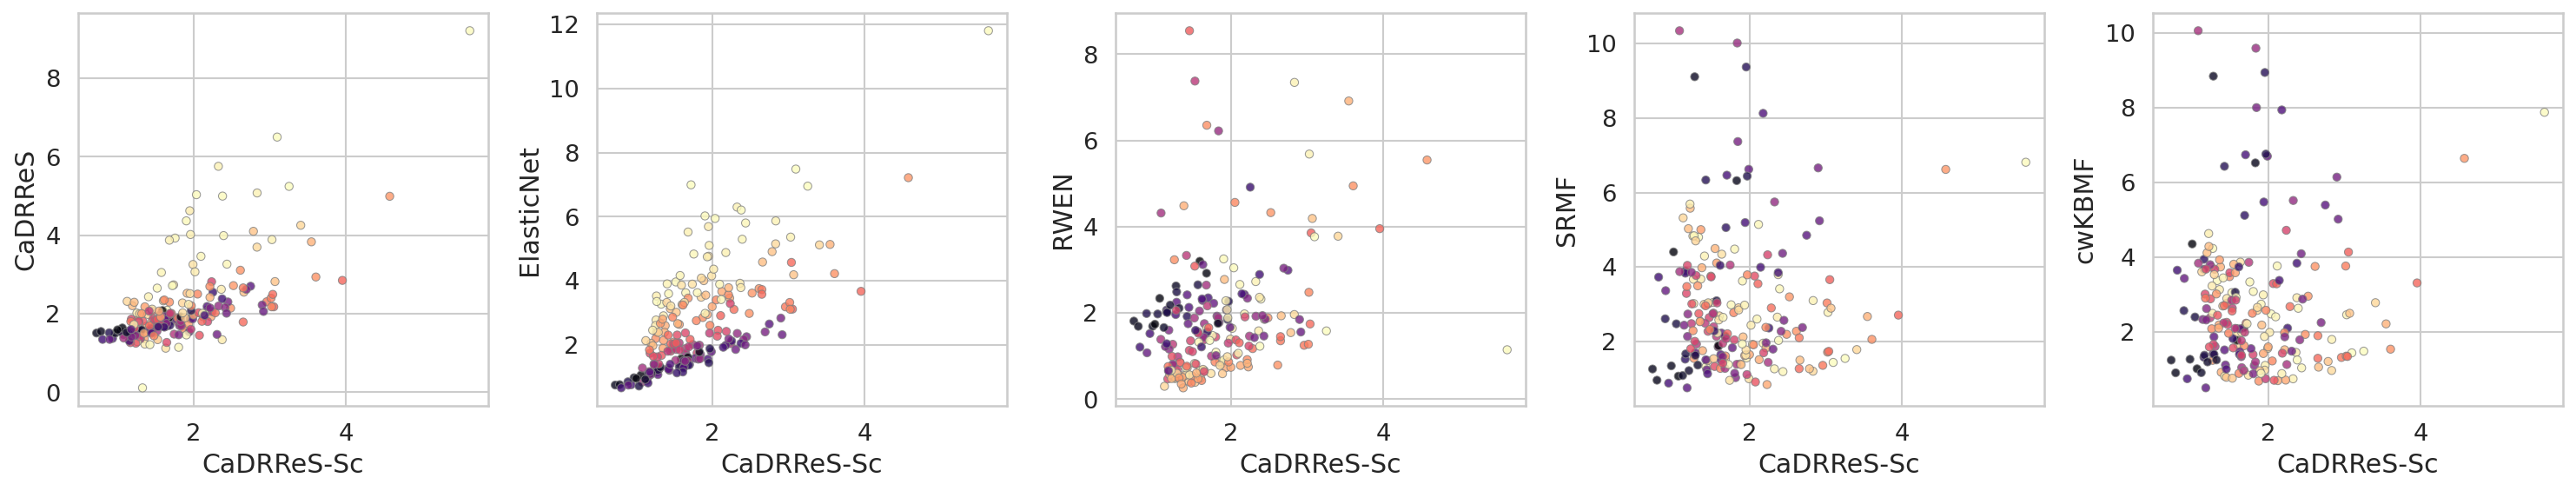

In [98]:
score_name = 'MedianAE' # MAE | Accuracy

sns.set(font_scale=1.2)
sns.set_style("whitegrid", {"axes.facecolor": "white"})
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

m1 = 'CaDRReS-Sc'
for m2, ax in zip(sorted([m for m in model_list if m != m1]), axes.flatten()):
    df = drug_result_df[drug_result_df['Model'].isin([m1, m2])].pivot(index='Drug', columns='Model', values=score_name)
    df = pd.merge(df, drug_df[['num_sensitive', 'num_cl']], left_index=True, right_index=True)
    df.loc[:, 'percent_sensitive'] = (drug_df['num_sensitive'] / drug_df['num_cl']) * 100
    sns.scatterplot(data=df, x=m1, y=m2, hue='percent_sensitive', s=20, alpha=0.8, edgecolor='grey', linewidth=0.5, ax=ax, palette='magma_r', vmin=0, vmax=100)
    ax.set_xlabel("{}".format(m1))
    ax.set_ylabel("{}".format(m2))
    
# #     if score_name == 'MAE':
# #         ax.plot((0, 6), (0, 6), linewidth=1, linestyle='--', color='grey')
# #         ax.set_xlim((0, 6))
# #         ax.set_ylim(bottom=0)
    
    ax.get_legend().remove()
    
plt.tight_layout()
plt.savefig('../figure/performance_scatter_MedianAE.svg')

1.80e-05


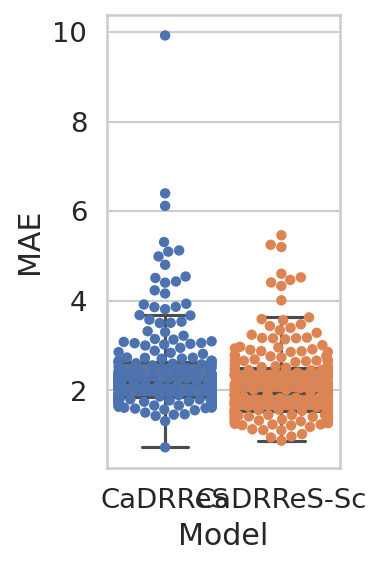

In [34]:
fig, ax = plt.subplots(figsize=(2, 4))

df = drug_result_df[drug_result_df['Model'].isin(['CaDRReS', 'CaDRReS-Sc'])][['Model', score_name]]
sns.boxplot(data=df, x='Model', y=score_name, fliersize=0, ax=ax)
sns.swarmplot(data=df, x='Model', y=score_name, ax=ax)

r, p = stats.ranksums(df[df['Model']=='CaDRReS'][score_name].values,
               df[df['Model']=='CaDRReS-Sc'][score_name].values
              )
print ("{:.2e}".format(p))

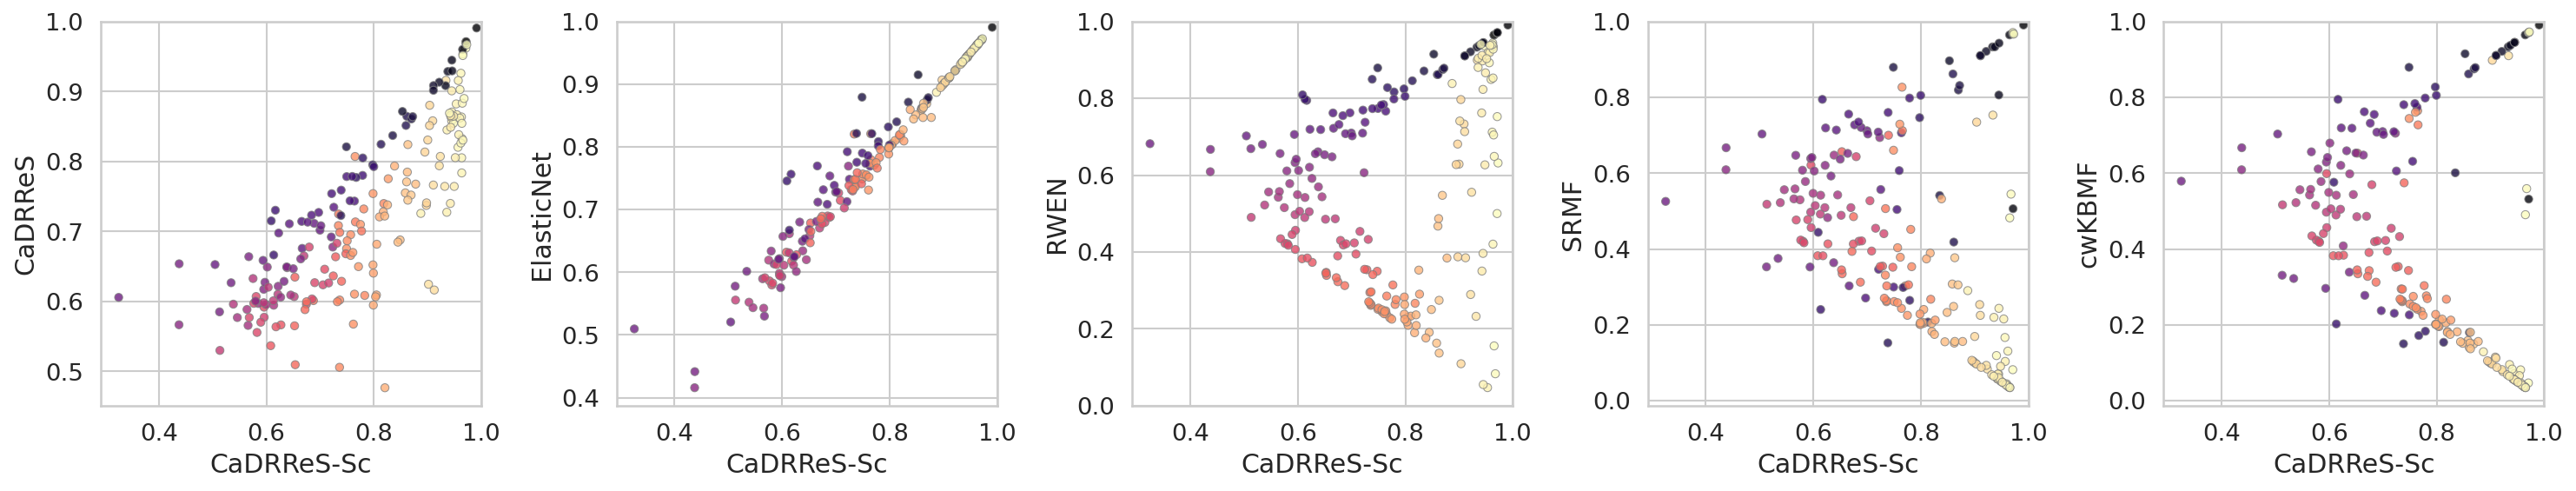

In [35]:
score_name = 'Accuracy' # MAE | Accuracy

sns.set(font_scale=1.2)
sns.set_style("whitegrid", {"axes.facecolor": "white"})
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

m1 = 'CaDRReS-Sc'
for m2, ax in zip(sorted([m for m in model_list if m != m1]), axes.flatten()):
    df = drug_result_df[drug_result_df['Model'].isin([m1, m2])].pivot(index='Drug', columns='Model', values=score_name)
    df = pd.merge(df, drug_df[['num_sensitive']], left_index=True, right_index=True)
    df.loc[:, 'percent_sensitive'] = (drug_df['num_sensitive'] / drug_df['num_cl']) * 100
    sns.scatterplot(data=df, x=m1, y=m2, hue='percent_sensitive', s=20, alpha=0.8, edgecolor='grey', linewidth=0.5, ax=ax, palette='magma_r', vmin=0, vmax=100)
    ax.set_xlabel("{}".format(m1, score_name))
    ax.set_ylabel("{}".format(m2, score_name))
    
#     ax.plot((0, 1), (0, 1), linewidth=1, linestyle='--', color='grey')
#     ax.set_xlim((0, 1))
    ax.set_ylim(top=1)
    ax.set_xlim(right=1)
    
    ax.get_legend().remove()
    
plt.tight_layout()
plt.savefig('../figure/performance_scatter_accuracy.svg')

2.66e-04


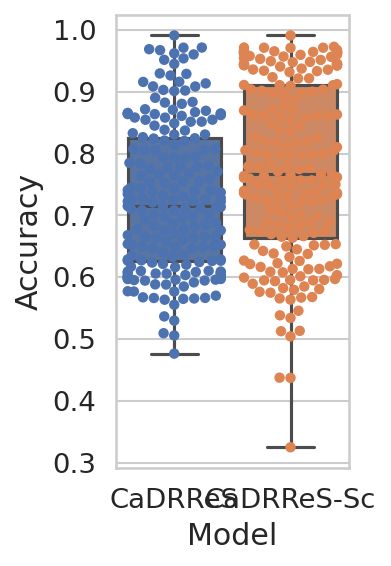

In [36]:
fig, ax = plt.subplots(figsize=(2, 4))

df = drug_result_df[drug_result_df['Model'].isin(['CaDRReS', 'CaDRReS-Sc'])][['Model', score_name]]
sns.boxplot(data=df, x='Model', y=score_name, fliersize=0, ax=ax)
sns.swarmplot(data=df, x='Model', y=score_name, ax=ax)

r, p = stats.ranksums(df[df['Model']=='CaDRReS'][score_name].values,
               df[df['Model']=='CaDRReS-Sc'][score_name].values
              )
print ("{:.2e}".format(p))

In [37]:
# score_name = 'PR-AUC' # MAE | Accuracy

# sns.set(font_scale=1.2)
# sns.set_style("whitegrid", {"axes.facecolor": "white"})
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

# m1 = 'CaDRReS-Sc'
# for m2, ax in zip(sorted([m for m in model_list if m != m1]), axes.flatten()):
#     df = drug_result_df[drug_result_df['Model'].isin([m1, m2])].pivot(index='Drug', columns='Model', values=score_name)
#     df = pd.merge(df, drug_df[['num_sensitive']], left_index=True, right_index=True)
#     sns.scatterplot(data=df, x=m1, y=m2, hue='num_sensitive', s=20, alpha=0.8, edgecolor='grey', linewidth=0.5, ax=ax, palette='magma_r')
#     ax.set_xlabel("{} ({})".format(m1, score_name))
#     ax.set_ylabel("{} ({})".format(m2, score_name))
    
#     ax.plot((0, 1), (0, 1), linewidth=1, linestyle='--', color='grey')
#     ax.set_xlim((0, 1))
#     ax.set_ylim(bottom=0)
    
#     ax.get_legend().remove()
    
# plt.tight_layout()
# plt.savefig('../figure/performance_scatter_pr_auc.svg')

## Indication-specific

In [38]:
# drug_result_indication_df = drug_result_indication_df[drug_result_indication_df['Indication weight'].isin([1, 10])]

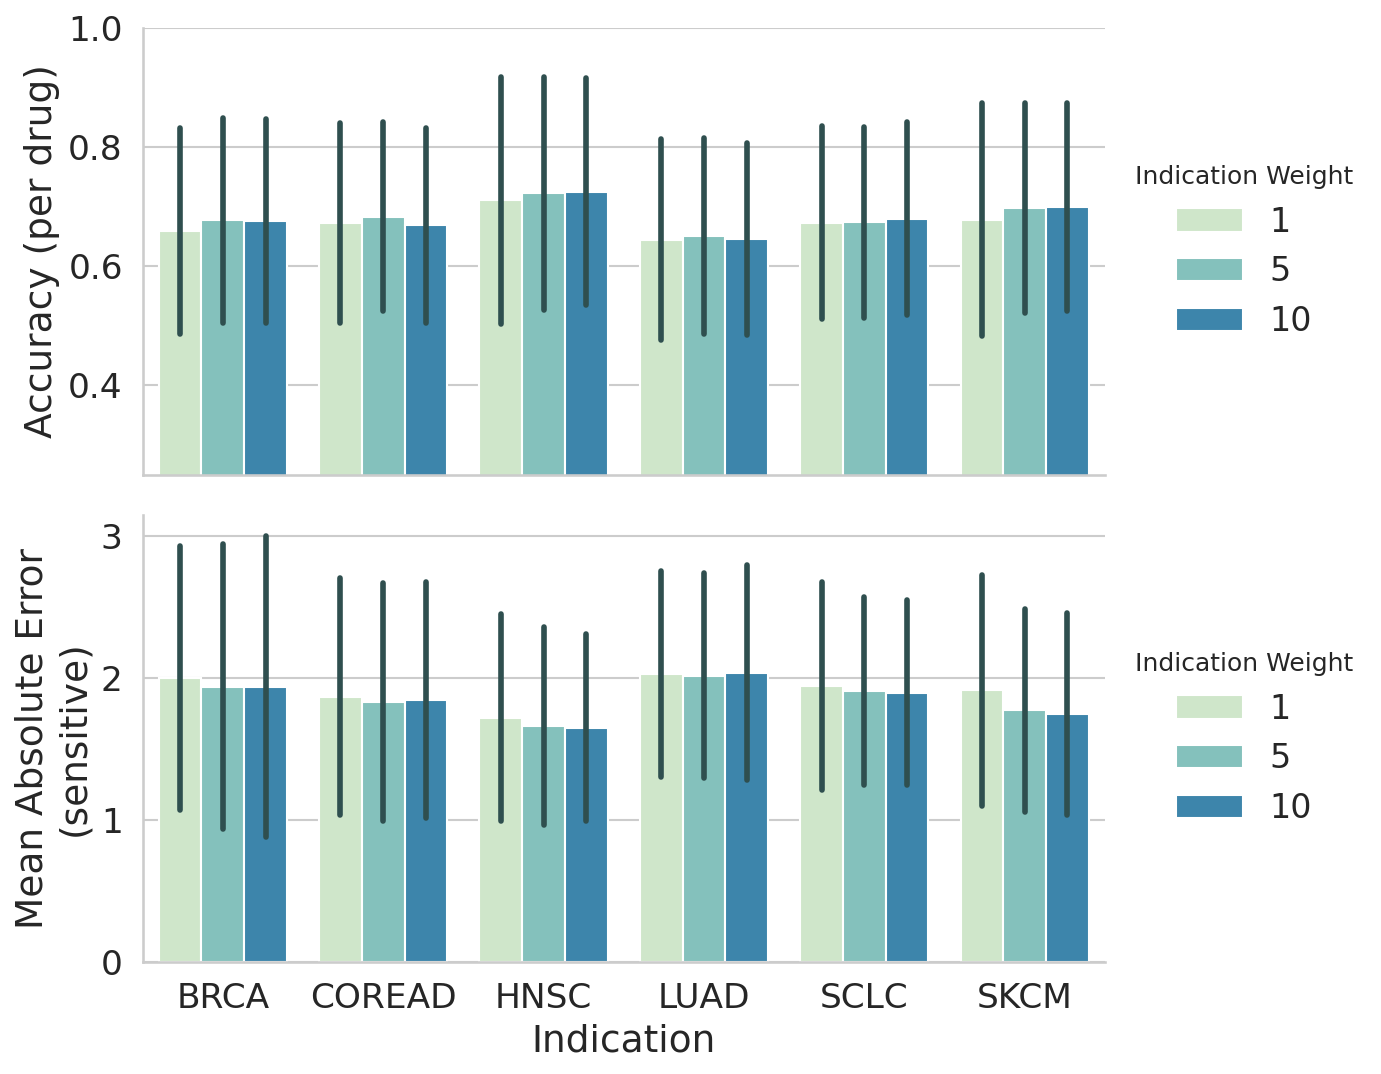

In [39]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {"axes.facecolor": "white"})
fig, axes = plt.subplots(nrows=2, figsize=(10,7.5), sharex=True)

pallete_name = 'GnBu'

ax = axes[0]
score_name = 'Accuracy'
# sns.boxplot(data=drug_result_indication_df, x='Indication', y=score_name, hue='Indication weight', fliersize=0, palette=pallete_name, ax=ax)
# sns.swarmplot(data=drug_result_indication_df, x='Indication', y=score_name, hue='Indication weight', s=0, alpha=0.75, color='black', split=True, ax=ax)
sns.barplot(data=drug_result_indication_df, x='Indication', y=score_name, hue='Indication weight', ci='sd', errcolor='darkslategrey', palette=pallete_name, ax=ax)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0, markerscale=1., fontsize=16, title='Indication Weight')
ax.set_ylim((0.25, 1))
ax.set_xlabel('')
ax.set_ylabel('Accuracy (per drug)')

ax = axes[1]
score_name = 'MAE'
# sns.boxplot(data=drug_result_indication_df, x='Indication', y=score_name, hue='Indication weight', fliersize=1, palette=pallete_name, ax=ax)
sns.barplot(data=drug_result_indication_df, x='Indication', y=score_name, hue='Indication weight', ci='sd', errcolor='darkslategrey', palette=pallete_name, ax=ax)
# sns.swarmplot(data=drug_result_indication_df, x='Indication', y=score_name, hue='Indication weight', s=2, alpha=0.75, palette=pallete_name, split=True, ax=ax)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0, markerscale=1., fontsize=16, title='Indication Weight')
# ax.set_ylim(bottom=0.3)
ax.set_ylabel('Mean Absolute Error\n(sensitive)')


plt.tight_layout(rect=(0, 0, 0.8, 1))
sns.despine()

plt.savefig('../figure/performance_indication_auc_mae.svg')